In [1]:
# ============================================================
# Notebook 03 — CNN field-to-field learning: x[t] -> x[t+1]
# ============================================================

import numpy as np
import xarray as xr
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 11


In [2]:
ZARR_PATH = "data/demo_eu_forecast.zarr"
ds = xr.open_zarr(ZARR_PATH, consolidated=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)
ds


device: mps


<xarray.Dataset> Size: 18MB
Dimensions:     (valid_time: 41, lat: 121, lon: 181)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 328B 2026-01-10 ... 2026-01-15
  * lat         (lat) float64 968B 35.0 35.31 35.62 35.92 ... 71.38 71.69 72.0
  * lon         (lon) float64 1kB -15.0 -14.72 -14.44 ... 34.44 34.72 35.0
    init_time   datetime64[ns] 8B ...
    lead_time   (valid_time) timedelta64[s] 328B dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    mslp        (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    t2m         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    tp          (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    u10         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    v10         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
Attributes:
    title:        Synthetic European Forecast Demo
    institution:  Demo dataset for Zarr tutorial
    history:      Created in Notebook 04

In [3]:
# ------------------------------------------------------------
# Load 4 input fields and target field into RAM
# ------------------------------------------------------------

t2m  = ds["t2m"].astype("float32").values   # (T, Y, X)
u10  = ds["u10"].astype("float32").values
v10  = ds["v10"].astype("float32").values
mslp = ds["mslp"].astype("float32").values

T, Y, X = t2m.shape
print("T,Y,X =", t2m.shape)


T,Y,X = (41, 121, 181)


In [4]:
# ------------------------------------------------------------
# Normalization (per channel)
# ------------------------------------------------------------

# stack inputs for stats: (T, C, Y, X)
Xin = np.stack([t2m, u10, v10, mslp], axis=1)

# channel mean/std over all times/space
X_mean = Xin.mean(axis=(0,2,3), keepdims=True)
X_std  = Xin.std(axis=(0,2,3), keepdims=True) + 1e-6

y_mean = t2m.mean()
y_std  = t2m.std() + 1e-6

print("X_mean:", X_mean.ravel())
print("X_std :", X_std.ravel())
print("y_mean/std:", float(y_mean), float(y_std))


X_mean: [ 1.05268450e+01  6.09911680e+00 -3.24490189e-04  1.01110535e+03]
X_std : [6.1527348 1.8643336 1.5508958 5.7956495]
y_mean/std: 10.526843070983887 6.152734756469727


In [5]:
# ------------------------------------------------------------
# Patch sampler: inputs = 4ch patch at time t, target = t2m patch at t+1
# ------------------------------------------------------------

def sample_patch_batch(batch_size=8, patch=64, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # sample random times (avoid last)
    it = rng.integers(0, T-1, size=batch_size)

    Xb = np.zeros((batch_size, 4, patch, patch), dtype=np.float32)
    yb = np.zeros((batch_size, 1, patch, patch), dtype=np.float32)

    for k in range(batch_size):
        t = int(it[k])
        y0 = rng.integers(0, Y - patch)
        x0 = rng.integers(0, X - patch)

        # input at t
        Xin_patch = np.stack([
            t2m[t,  y0:y0+patch, x0:x0+patch],
            u10[t,  y0:y0+patch, x0:x0+patch],
            v10[t,  y0:y0+patch, x0:x0+patch],
            mslp[t, y0:y0+patch, x0:x0+patch],
        ], axis=0)

        # target at t+1
        y_patch = t2m[t+1, y0:y0+patch, x0:x0+patch][None, :, :]

        # normalize
        Xin_patch = (Xin_patch - X_mean[0]) / X_std[0]
        y_patch   = (y_patch - y_mean) / y_std

        Xb[k] = Xin_patch
        yb[k] = y_patch

    Xt = torch.from_numpy(Xb).to(device)
    yt = torch.from_numpy(yb).to(device)
    return Xt, yt


# sanity check
Xt, yt = sample_patch_batch(batch_size=2, patch=64, rng=np.random.default_rng(0))
print("Xt:", Xt.shape, "yt:", yt.shape)


Xt: torch.Size([2, 4, 64, 64]) yt: torch.Size([2, 1, 64, 64])


In [6]:
# ------------------------------------------------------------
# Small CNN: 4ch -> 1ch
# ------------------------------------------------------------

class SmallCNN(nn.Module):
    def __init__(self, in_ch=4, out_ch=1, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, out_ch, 1),
        )

    def forward(self, x):
        return self.net(x)

model = SmallCNN().to(device)
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=2e-3)

model


SmallCNN(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

step  100 | loss = 1.3200e-02
step  200 | loss = 8.8209e-03
step  300 | loss = 1.6242e-02
step  400 | loss = 5.8078e-03
step  500 | loss = 6.5752e-03
step  600 | loss = 9.7021e-03
step  700 | loss = 7.8991e-03
step  800 | loss = 5.7215e-03
step  900 | loss = 7.3359e-03
step 1000 | loss = 7.7283e-03
step 1100 | loss = 8.5712e-03
step 1200 | loss = 5.8265e-03
step 1300 | loss = 4.3688e-03
step 1400 | loss = 5.7123e-03
step 1500 | loss = 4.4480e-03


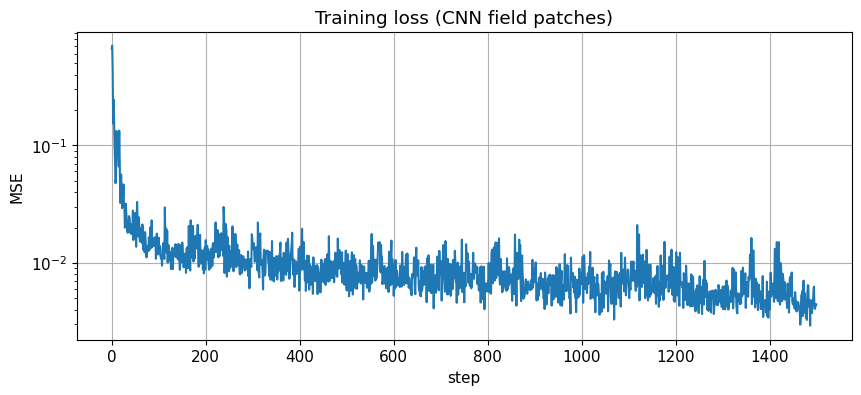

In [7]:
# ------------------------------------------------------------
# Train CNN on patches
# ------------------------------------------------------------

rng = np.random.default_rng(123)
n_steps = 1500
batch_size = 8
patch = 64

loss_hist = []

model.train()
for step in range(1, n_steps + 1):
    Xt, yt = sample_patch_batch(batch_size=batch_size, patch=patch, rng=rng)

    pred = model(Xt)
    loss = loss_fn(pred, yt)

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_hist.append(float(loss.item()))
    if step % 100 == 0:
        print(f"step {step:4d} | loss = {loss_hist[-1]:.4e}")

plt.semilogy(loss_hist)
plt.title("Training loss (CNN field patches)")
plt.xlabel("step")
plt.ylabel("MSE")
plt.grid(True)
plt.savefig("zarr_training_loss.png")
plt.show()


Full-field RMSE: 0.3758298456668854


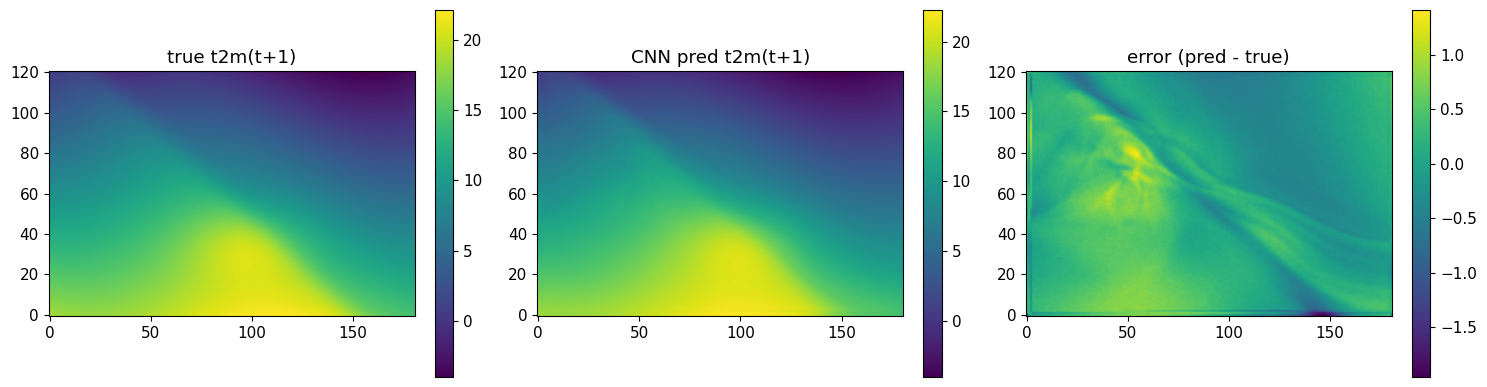

In [8]:
# ------------------------------------------------------------
# Evaluate on full field: predict t2m(t+1) from fields at t
# ------------------------------------------------------------

t_test = 5  # choose any time index < T-1

# build full input field (1,4,Y,X)
X_full = np.stack([t2m[t_test], u10[t_test], v10[t_test], mslp[t_test]], axis=0)[None].astype(np.float32)
X_full = (X_full - X_mean) / X_std

Xt = torch.from_numpy(X_full).to(device)

model.eval()
with torch.no_grad():
    y_pred_n = model(Xt).detach().cpu().numpy()[0,0]

# unnormalize
y_pred = y_pred_n * y_std + y_mean
y_true = t2m[t_test+1]

rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
print("Full-field RMSE:", rmse)

# plot truth vs pred vs error
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
im0 = axs[0].imshow(y_true, origin="lower")
axs[0].set_title("true t2m(t+1)")
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(y_pred, origin="lower")
axs[1].set_title("CNN pred t2m(t+1)")
plt.colorbar(im1, ax=axs[1], fraction=0.046)

im2 = axs[2].imshow(y_pred - y_true, origin="lower")
axs[2].set_title("error (pred - true)")
plt.colorbar(im2, ax=axs[2], fraction=0.046)

plt.tight_layout()
plt.savefig("zarr_training_outcome.png")
plt.show()


Rollout RMSE by step:
lead   0 h | RMSE = 0.0000
lead   3 h | RMSE = 0.5052
lead   6 h | RMSE = 0.9963
lead   9 h | RMSE = 1.4722
lead  12 h | RMSE = 1.9296
lead  15 h | RMSE = 2.3664
lead  18 h | RMSE = 2.7901
lead  21 h | RMSE = 3.2157
lead  24 h | RMSE = 3.6599
lead  27 h | RMSE = 4.1267
lead  30 h | RMSE = 4.5936
lead  33 h | RMSE = 5.0432
lead  36 h | RMSE = 5.4748
lead  39 h | RMSE = 5.8885
lead  42 h | RMSE = 6.2789
lead  45 h | RMSE = 6.6416
lead  48 h | RMSE = 6.9892
lead  51 h | RMSE = 7.3368
lead  54 h | RMSE = 7.6928
lead  57 h | RMSE = 8.0564
lead  60 h | RMSE = 8.4468


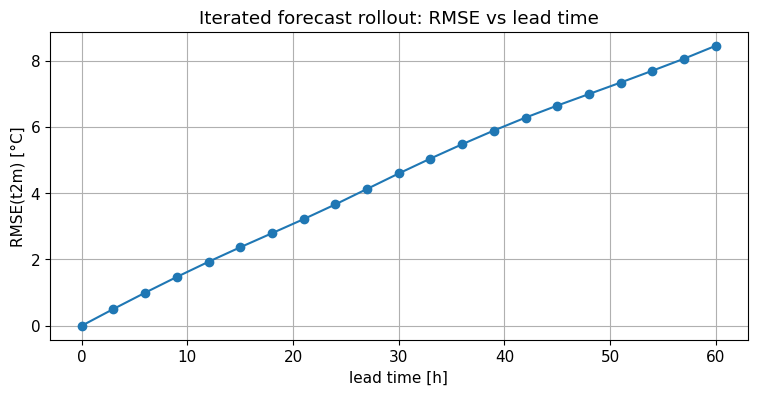

In [9]:
# ------------------------------------------------------------
# Iterated forecast rollout from initial time t0
# CNN predicts t2m, while u10/v10/mslp are taken from truth (teacher forcing)
# ------------------------------------------------------------

import numpy as np
import torch
import matplotlib.pyplot as plt

t0 = 0            # initial index (valid_time index)
n_forecast = 20   # number of rollout steps (each step = 3h in our data)

assert t0 + n_forecast < T-1

def normalize_input(t2m_f, u10_f, v10_f, mslp_f):
    X = np.stack([t2m_f, u10_f, v10_f, mslp_f], axis=0)[None].astype(np.float32)  # (1,4,Y,X)
    Xn = (X - X_mean) / X_std
    return torch.from_numpy(Xn).to(device)

def unnormalize_t2m(y_n):
    # y_n shape: (1,1,Y,X)
    y = y_n[0,0] * y_std + y_mean
    return y

# --- initial conditions ---
t2m_hat = t2m[t0].copy()          # predicted t2m starts at truth t0
t2m_true_list = []
t2m_pred_list = []

lead_hours = []
vt = ds["valid_time"].values
lead_h_all = ((vt - vt[0]) / np.timedelta64(1, "h")).astype(int)

# store initial
t2m_true_list.append(t2m[t0])
t2m_pred_list.append(t2m_hat)
lead_hours.append(int(lead_h_all[t0]))

# --- rollout ---
model.eval()
with torch.no_grad():
    for k in range(1, n_forecast + 1):
        t = t0 + (k - 1)

        # teacher forcing: take u/v/mslp from truth at time t
        Xt = normalize_input(
            t2m_hat,
            u10[t],
            v10[t],
            mslp[t],
        )

        # predict next-step t2m (normalized)
        y_pred_n = model(Xt).detach().cpu().numpy()  # (1,1,Y,X)
        t2m_hat = unnormalize_t2m(y_pred_n).astype(np.float32)

        # store
        t2m_true_list.append(t2m[t0 + k])
        t2m_pred_list.append(t2m_hat)
        lead_hours.append(int(lead_h_all[t0 + k]))

# convert to arrays: (steps+1, Y, X)
t2m_true_arr = np.stack(t2m_true_list, axis=0)
t2m_pred_arr = np.stack(t2m_pred_list, axis=0)

# --- compute RMSE per lead time ---
rmse = np.sqrt(np.mean((t2m_pred_arr - t2m_true_arr)**2, axis=(1,2)))

print("Rollout RMSE by step:")
for k in range(len(rmse)):
    print(f"lead {lead_hours[k]:3d} h | RMSE = {rmse[k]:.4f}")

# --- plot RMSE curve ---
plt.figure(figsize=(9,4))
plt.plot(lead_hours, rmse, "-o")
plt.title("Iterated forecast rollout: RMSE vs lead time")
plt.xlabel("lead time [h]")
plt.ylabel("RMSE(t2m) [°C]")
plt.grid(True)
plt.savefig("zarr_forecast_rmse.png")
plt.show()


In [10]:
# ------------------------------------------------------------
# Save town forecast plots: fc_<town>.png
# Requires: lead_hours, t2m_true_arr, t2m_pred_arr
# ------------------------------------------------------------

import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Example towns (extend as you like)
TOWNS = {
    "Berlin":    (52.5200, 13.4050),
    "Hamburg":   (53.5511,  9.9937),
    "Munich":    (48.1351, 11.5820),
    "Cologne":   (50.9375,  6.9603),
    "Frankfurt": (50.1109,  8.6821),
    "Paris":     (48.8566,  2.3522),
    "Vienna":    (48.2082, 16.3738),
    "Prague":    (50.0755, 14.4378),
}

OUTDIR = "town_forecasts"
os.makedirs(OUTDIR, exist_ok=True)

def safe_name(s):
    s = s.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

lat_arr = ds["lat"].values
lon_arr = ds["lon"].values

for town, (lat0, lon0) in TOWNS.items():
    # nearest gridpoint indices
    iy = int(np.argmin(np.abs(lat_arr - lat0)))
    ix = int(np.argmin(np.abs(lon_arr - lon0)))

    latg = float(lat_arr[iy])
    long = float(lon_arr[ix])

    # extract series
    y_true = t2m_true_arr[:, iy, ix]
    y_pred = t2m_pred_arr[:, iy, ix]

    rmse_town = float(np.sqrt(np.mean((y_pred - y_true)**2)))

    # plot
    plt.figure(figsize=(10, 4))
    plt.plot(lead_hours, y_true, "-o", markersize=4, linewidth=1, label="true t2m")
    plt.plot(lead_hours, y_pred, "-o", markersize=4, linewidth=1, label="CNN forecast t2m")

    plt.title(f"{town}: iterated forecast vs truth (RMSE={rmse_town:.3f}°C)\n"
              f"gridpoint=({latg:.3f},{long:.3f})")
    plt.xlabel("lead time [h]")
    plt.ylabel("t2m [°C]")
    plt.grid(True)
    plt.legend()

    # save
    fn = os.path.join(OUTDIR, f"fc_{safe_name(town)}.png")
    plt.tight_layout()
    plt.savefig(fn, dpi=160)
    plt.close()

    print("saved:", fn)

print("Done. Output folder:", OUTDIR)


saved: town_forecasts/fc_berlin.png
saved: town_forecasts/fc_hamburg.png
saved: town_forecasts/fc_munich.png
saved: town_forecasts/fc_cologne.png
saved: town_forecasts/fc_frankfurt.png
saved: town_forecasts/fc_paris.png
saved: town_forecasts/fc_vienna.png
saved: town_forecasts/fc_prague.png
Done. Output folder: town_forecasts


Found 8 plots in town_forecasts


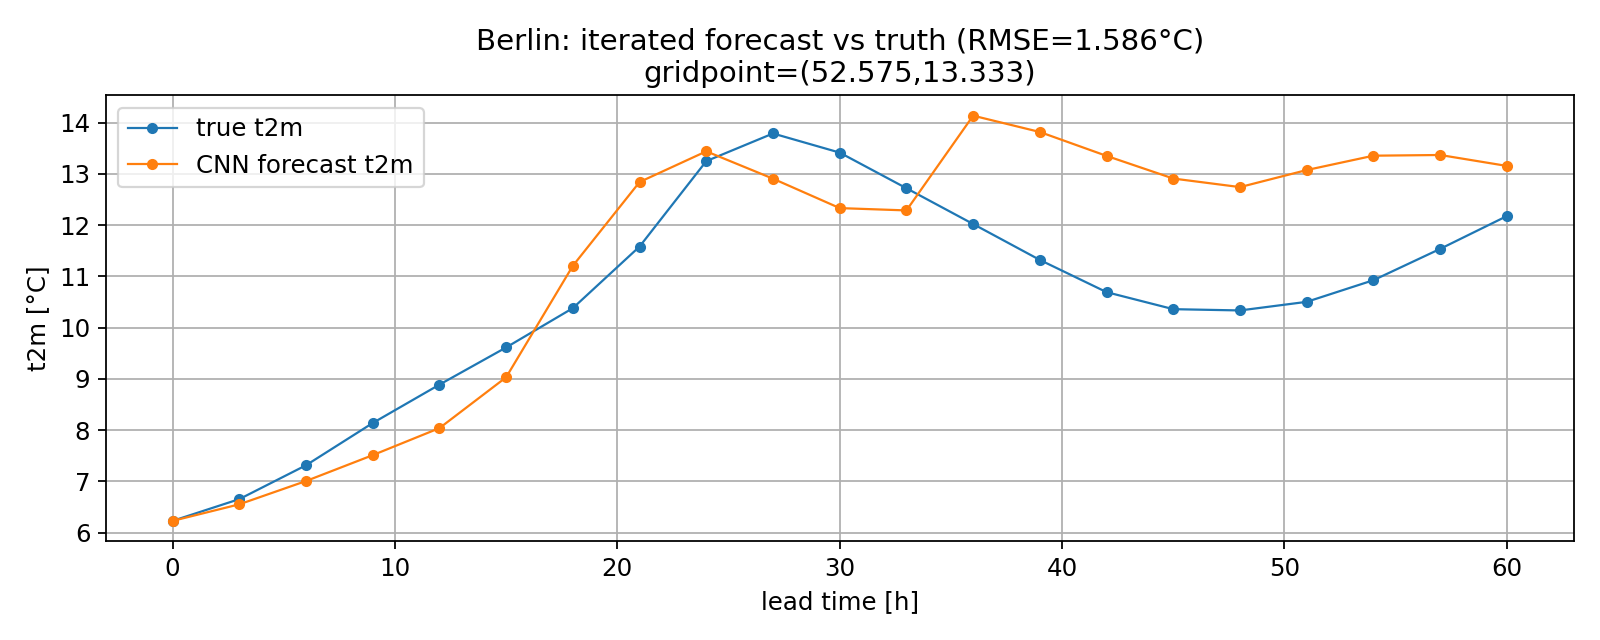

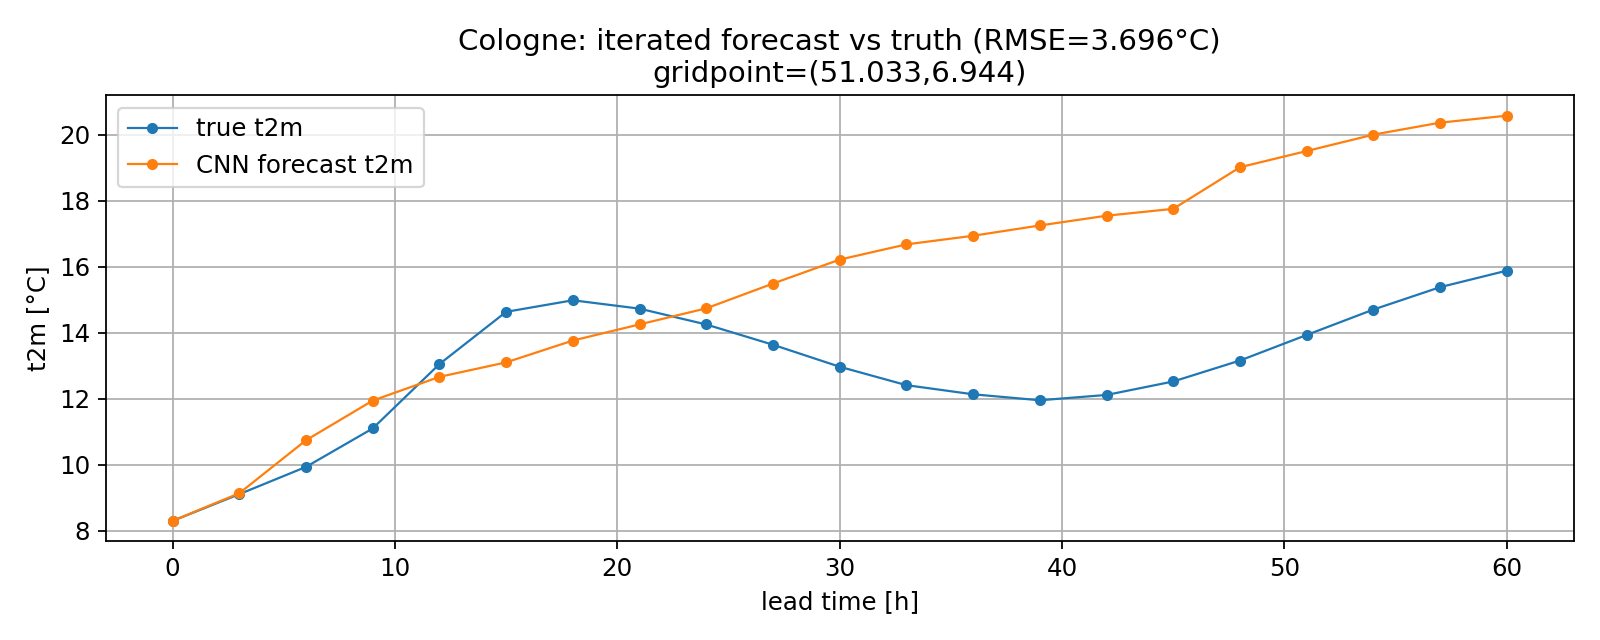

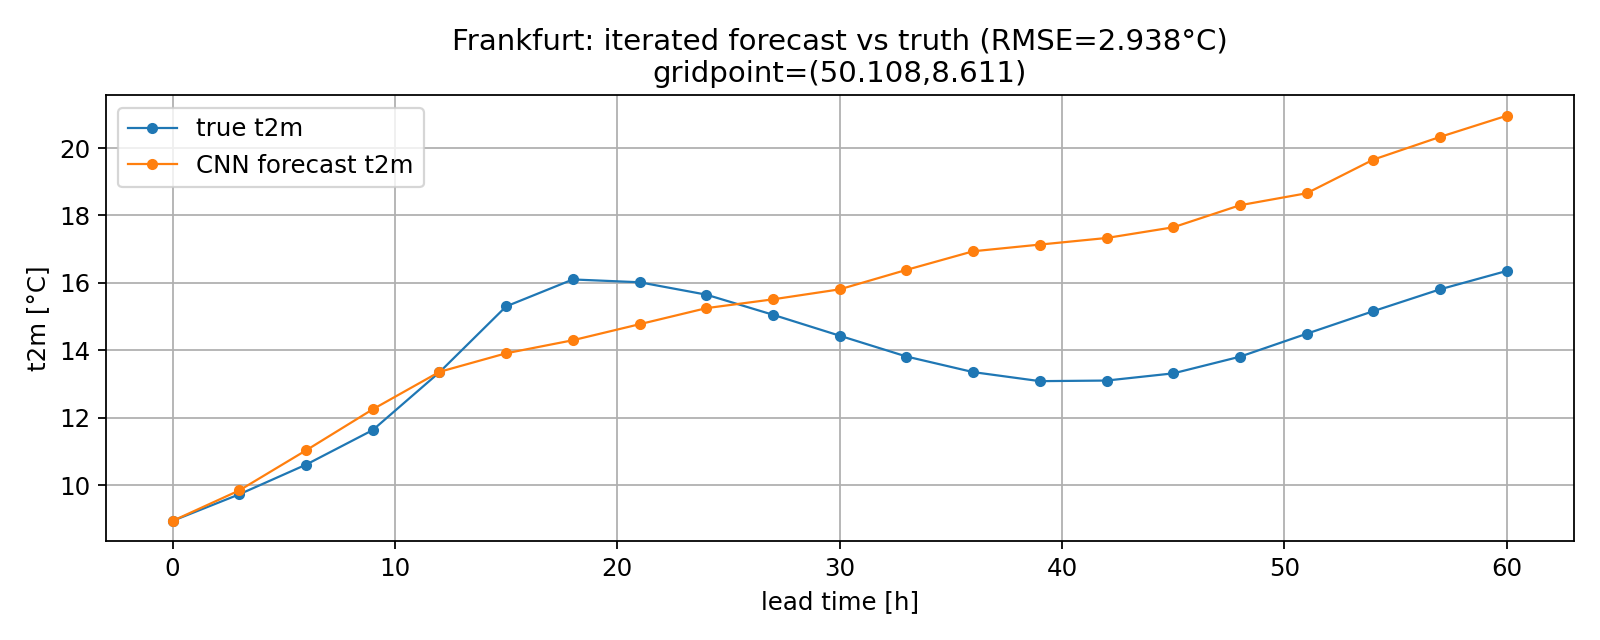

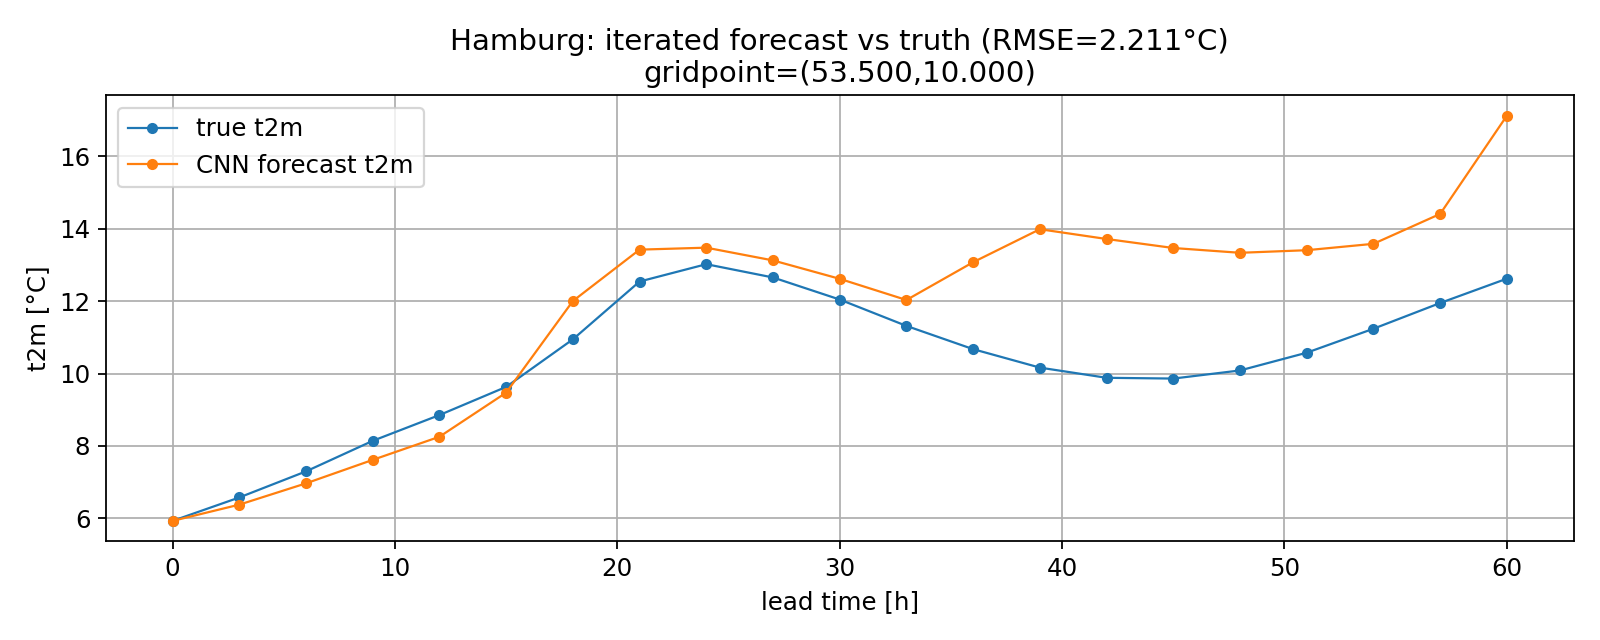

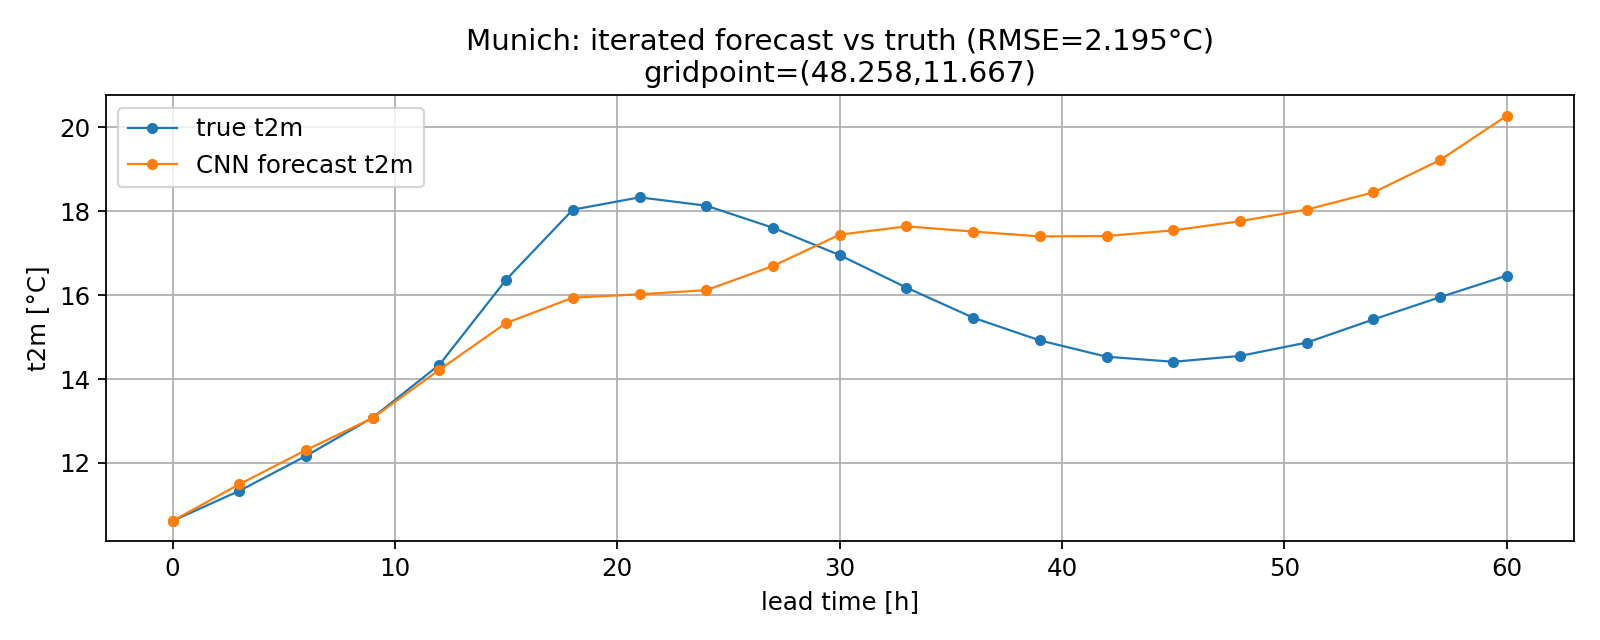

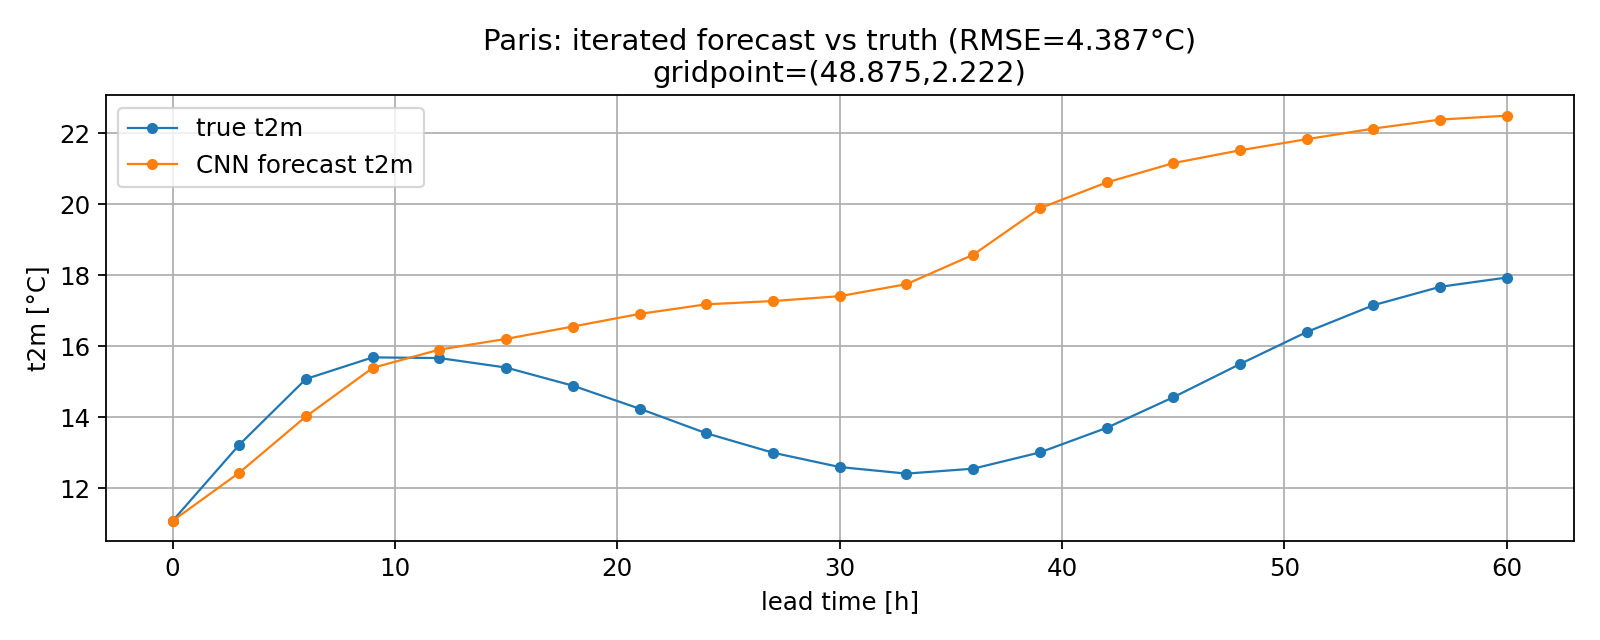

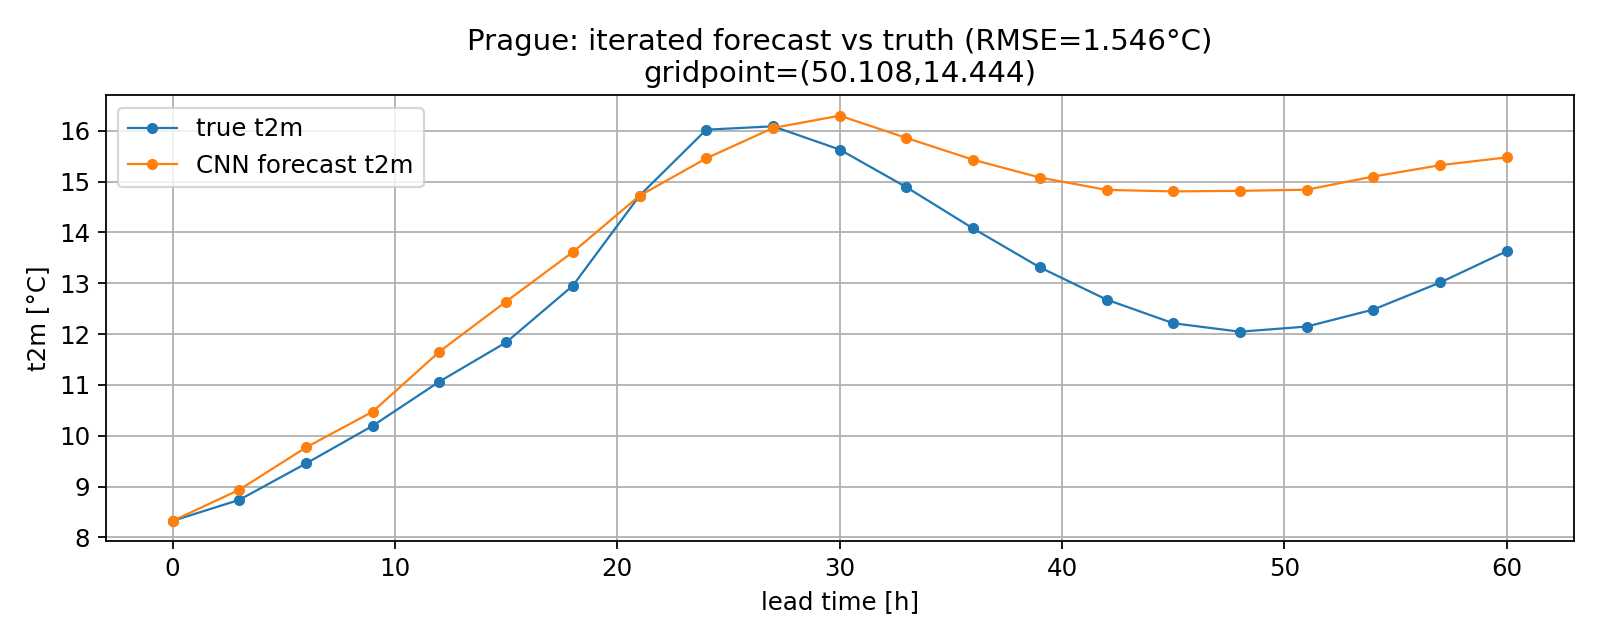

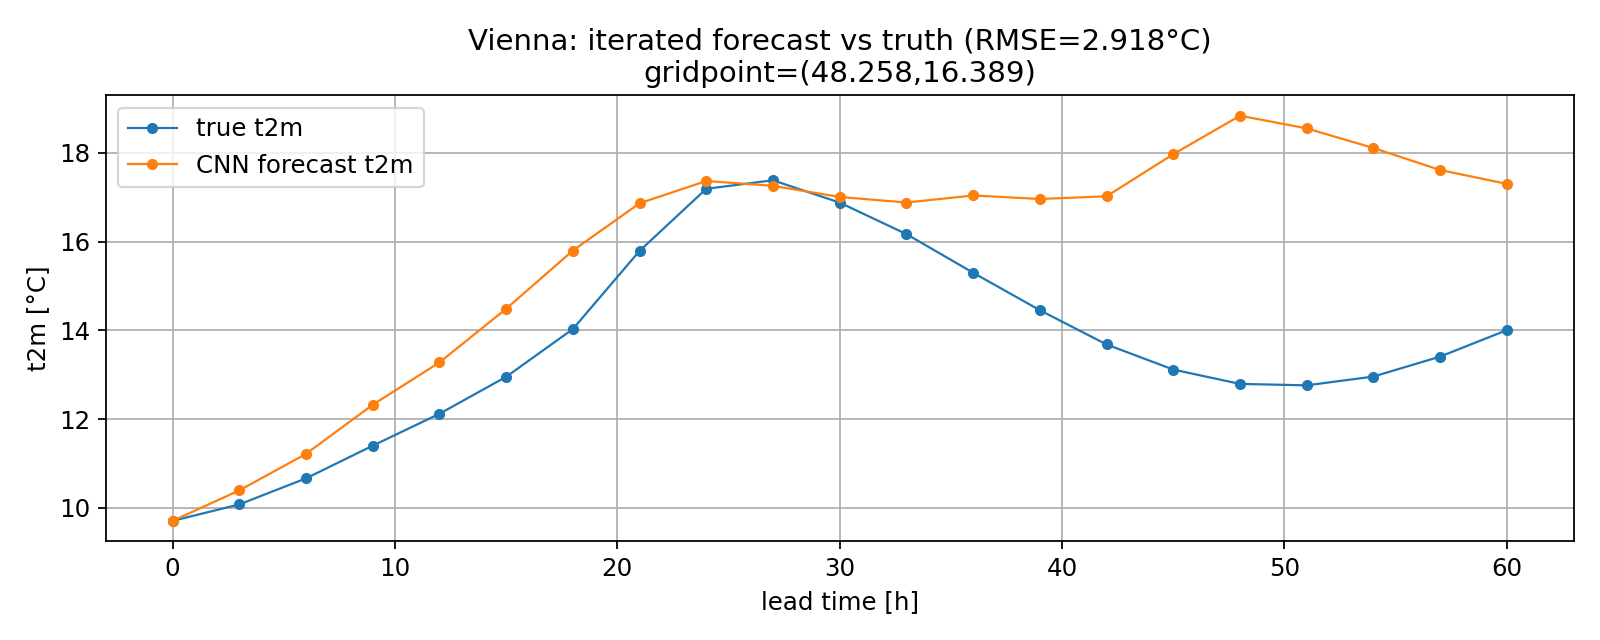

In [11]:
# ------------------------------------------------------------
# Show all saved town forecast plots in the notebook
# ------------------------------------------------------------

import os
import glob
from IPython.display import Image, display

OUTDIR = "town_forecasts"

pngs = sorted(glob.glob(os.path.join(OUTDIR, "fc_*.png")))

print(f"Found {len(pngs)} plots in {OUTDIR}")
for fn in pngs:
    display(Image(filename=fn))